In [72]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Subhashish_personal/comcast_consumeraffairs_complaints.csv')
df1 = df.head(1000)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install hdbscan

In [ ]:
! pip install bertopic

In [ ]:
! pip install nltk

# BerTopic

In [ ]:
df1

In [73]:
df

,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...
...,...,...,...,...
5654,"Brandye of San Ramon, CA","March 12, 2006",0,"Last year, we bought the Nascar In Car package..."
5655,"Paul of Chicago, IL","March 12, 2006",0,Their billing department is horrid. If you dec...
5656,"Autumn of Knoxville, TN","March 6, 2006",0,"Ordered ""On Demand"" movie for the 1st time in ..."
5657,"Tina of Villa Rica, GA","Feb. 22, 2006",0,I am being ripped of by Comcast Cable regardin...


In [74]:
df.shape

(5659, 4)

In [75]:
df['text'].isnull().sum()

30

In [76]:
# removing rows which does not contains any review

df.dropna(inplace = True)

In [77]:
df['text'].isnull().sum() , df.shape

(0, (5629, 4))

In [78]:
# removing rows which contains invalid/only numbers in the review

df = df[df['text'].str.contains('[a-zA-Z]', na=False)]

In [79]:
df.shape

(5629, 4)

In [80]:
(df['rating'] >= 2).sum()

365

In [81]:
# removing reviews which are having rating higher than 2
# as we are clustering reviews which have problem so we are only finding -ve reviews and -ve reviews cannot have high rating

df = df[df['rating'] < 2]

In [82]:
df.shape

(5264, 4)

In [83]:
df = df[df['text'].str.len() <= 2000]

In [84]:
df.shape

(4439, 4)

In Clustering algorithm choosing Agglomerative over HDBSCAN as in Agglomerative we can define the number of cluster required

In [109]:
from sentence_transformers import SentenceTransformer
import umap
from hdbscan import HDBSCAN
import tensorflow_hub
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired


ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)
representation_model = KeyBERTInspired()


#embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_model = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

umap_model = umap.UMAP(n_neighbors=3, n_components=3, min_dist=0.05)

# using AgglomerativeClustering clustering as in it we can define the number of clusters required

#hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=40,
                        #gen_min_span_tree=True,
                        #prediction_data=True)
#cluster_model = KMeans(n_clusters=15)

# making educated guess and hit and try method on number of clusters
cluster_model = AgglomerativeClustering(n_clusters = 15)


In [93]:
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# removing basics stop words and problem specific words

stopwords = list(stopwords.words('english'))
exclude = ["comcast",'will', "get", "would",'us','way','area','minutes','month','year','back','said','told','call','called','asked','time','box','boxes','phone','company','customer',
           'day','could','can','customers','calls','service','services','even','now','going','want','lot']
stopwords.extend(exclude)

# we add this to remove stopwords that can pollute topics
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stopwords

In [110]:
from bertopic import BERTopic

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=cluster_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model ,
    representation_model=representation_model,
    top_n_words = 6,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(df['text'])

100%|██████████| 4439/4439 [00:10<00:00, 410.00it/s]
2023-10-15 07:29:18,005 - BERTopic - Transformed documents to Embeddings
2023-10-15 07:29:22,137 - BERTopic - Reduced dimensionality
2023-10-15 07:29:22,597 - BERTopic - Clustered reduced embeddings


In [59]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,448,0_collection agency_billing_payments_owed,"[collection agency, billing, payments, owed, c...",[Two months ago I contacted the collection age...
1,1,446,1_xfinity_directv_cable_billing,"[xfinity, directv, cable, billing, modem, prob...","[3 years ago, we moved to a new address and I ..."
2,2,380,2_billing_bill_cable_charged,"[billing, bill, cable, charged, charges, cancel]",[I have been a Cable customer with Comcast at ...
3,3,372,3_cable_basic cable_channels_xfinity,"[cable, basic cable, channels, xfinity, channe...",[I have been a Comcast Customer since 9/2004. ...
4,4,362,4_reschedule_appointment_appt_technician,"[reschedule, appointment, appt, technician, su...",[I was supposed to have my phone and internet ...
5,5,361,5_supervisor_problems_department_disconnected,"[supervisor, problems, department, disconnecte...",[I have been with Comcast for 16 months and ev...
6,6,308,6_pay bill_billing_billed_first bill,"[pay bill, billing, billed, first bill, bill, ...","[I am a seasonal customer from Port Charlotte,..."
7,7,290,7_cable_xfinity_cables_technician,"[cable, xfinity, cables, technician, dvr, inst...",[I have been a loyal customer of Comcast for o...
8,8,277,8_cable_outages_xfinity_fix problem,"[cable, outages, xfinity, fix problem, problem...",[Comcast offers a nice selection of free and o...
9,9,268,9_outage_xfinity_techs_problems,"[outage, xfinity, techs, problems, emails, cable]",[About 3 weeks ago Comcast added a home phone ...


In [ ]:
model.get_topic(0)

In [ ]:
model.get_representative_docs(34)

In [ ]:
model.visualize_barchart()

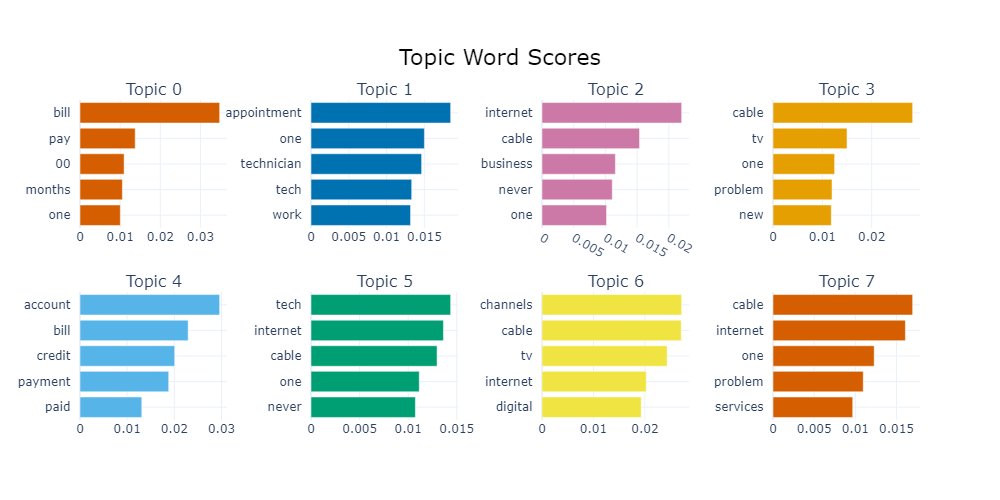

3 clusters are formed according to the words represent in the Representation Column

1. Billing Related issue / Hidden Charges
2. Outage / Internet speed related
3. Service of customer care

In [2]:
model.visualize_topics()

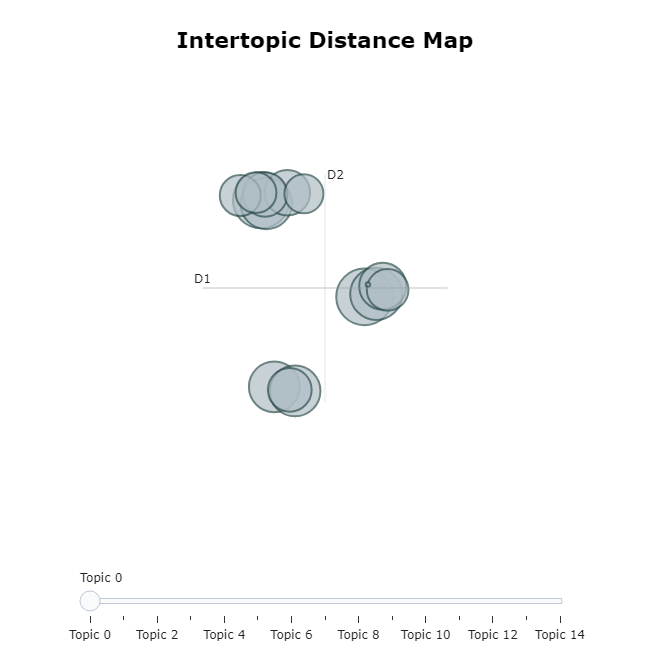

# Level C / Problem 3

In [61]:
# Adding a new column with topic number of BertTopic model

df['topic_number'] = topics

In [62]:
df

,author,posted_on,rating,text,topic_number
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...,11
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...,11
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...,1
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...,2
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...,10
...,...,...,...,...,...
5654,"Brandye of San Ramon, CA","March 12, 2006",0,"Last year, we bought the Nascar In Car package...",5
5655,"Paul of Chicago, IL","March 12, 2006",0,Their billing department is horrid. If you dec...,2
5656,"Autumn of Knoxville, TN","March 6, 2006",0,"Ordered ""On Demand"" movie for the 1st time in ...",6
5657,"Tina of Villa Rica, GA","Feb. 22, 2006",0,I am being ripped of by Comcast Cable regardin...,3


In [ ]:
model.get_representative_docs(4)

In [63]:
# As 2-3 topics mean to a similar type of issue so mapping each topic to overall type of problem

topic_number_map = {4: "Service related", 5: "Service related", 9: "Service related",
            0: "Billing related", 2: "Billing related", 6: "Billing related", 10: "Billing related", 14: "Billing related",
            1: "Outage / Speed", 3: "Outage / Speed", 7: "Outage / Speed", 8: "Outage / Speed", 11: "Outage / Speed", 12: "Outage / Speed", 13: "Outage / Speed"}

In [64]:
topic_number_map

{4: 'Service related',
 5: 'Service related',
 9: 'Service related',
 0: 'Billing related',
 2: 'Billing related',
 6: 'Billing related',
 10: 'Billing related',
 14: 'Billing related',
 1: 'Outage / Speed',
 3: 'Outage / Speed',
 7: 'Outage / Speed',
 8: 'Outage / Speed',
 11: 'Outage / Speed',
 12: 'Outage / Speed',
 13: 'Outage / Speed'}

In [65]:
# adding topic / classifing each review in topics column

df['Topics'] = df['topic_number'].map(topic_number_map)

In [66]:
df

,author,posted_on,rating,text,topic_number,Topics
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...,11,Outage / Speed
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...,11,Outage / Speed
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...,1,Outage / Speed
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...,2,Billing related
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...,10,Billing related
...,...,...,...,...,...,...
5654,"Brandye of San Ramon, CA","March 12, 2006",0,"Last year, we bought the Nascar In Car package...",5,Service related
5655,"Paul of Chicago, IL","March 12, 2006",0,Their billing department is horrid. If you dec...,2,Billing related
5656,"Autumn of Knoxville, TN","March 6, 2006",0,"Ordered ""On Demand"" movie for the 1st time in ...",6,Billing related
5657,"Tina of Villa Rica, GA","Feb. 22, 2006",0,I am being ripped of by Comcast Cable regardin...,3,Outage / Speed


In [68]:
# creating new dataframe containing review,topic

df_with_topic = pd.DataFrame()
df_with_topic['TextWithTopic'] = df['text'].astype(str) + ',' + df['Topics'].astype(str)

In [69]:
df_with_topic

,TextWithTopic
0,I used to love Comcast. Until all these consta...
1,I'm so over Comcast! The worst internet provid...
2,If I could give them a negative star or no sta...
3,I've had the worst experiences so far since in...
4,Check your contract when you sign up for Comca...
...,...
5654,"Last year, we bought the Nascar In Car package..."
5655,Their billing department is horrid. If you dec...
5656,"Ordered ""On Demand"" movie for the 1st time in ..."
5657,I am being ripped of by Comcast Cable regardin...


In [71]:
# converting the dataframe into .csv file

df_with_topic.to_csv('/content/drive/MyDrive/Subhashish_personal/title.csv' , index = False)